In [1]:
import sys
import numpy as np
from spectres import spectres
from matplotlib import pyplot as plt
from astropy.io import fits
sys.path.append('aspired')

import aspired

In [2]:
# Example data from SPRAT
# A spectrum with the host galaxy and a (super)nova(?) with only emission line
science_data = fits.open('examples/v_e_20190522_8_1_0_9.fits')[0].data

# Example data from SPRAT
# BDp33_2642_zpol (Blue)
standard_data = fits.open('examples/v_s_20190616_34_1_0_2.fits')[0].data

In [3]:
# Set the spectral and spatial direction
Saxis = 1
Waxis = 0

# example of initialising aspired.TwoDSpec() with cosmic ray removal in the pixel range covered by spatial_mask.
at2019 = aspired.TwoDSpec(science_data, rn=2.34, cr=False, gain=2.45, seeing=1.2, display=True)
bdp33 = aspired.TwoDSpec(standard_data, rn=2.34, cr=True, gain=2.45, seeing=1.2, display=True)

Tracing Aperture using nsteps=20
Tracing Aperture using nsteps=20


aspired/aspired.py:635: RuntimeWarning: invalid value encountered in log10
  np.log10(self.img),


Spectrum 1 : Trace gaussian width = [0.47934352 2.02593634 2.63683888 2.58004088 2.60954593 2.63750609
 2.64699183 2.64403439 2.6327098  2.62813821 2.61170919 2.59431007
 2.58050669 2.57676853 2.56601266 2.56665145 2.55931487 2.6440953
 2.70581142 0.        ] pixels


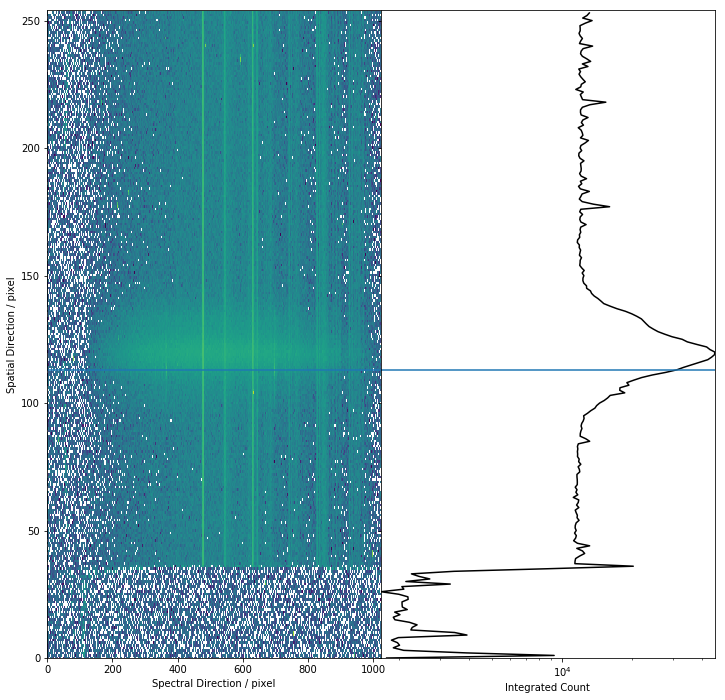

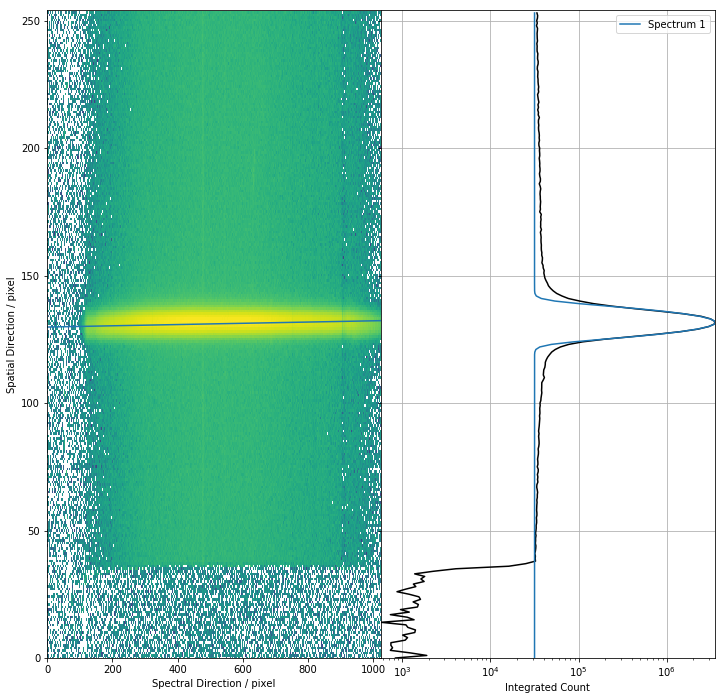

In [4]:
trace = np.ones(np.shape(science_data)[1])*113.

# manually provide trace, recenter is off so it does not wander off.
at2019.ap_trace(nsteps=20, recenter=False, prevtrace=trace, fittype='polynomial', order=1, bigbox=3)
bdp33.ap_trace(nsteps=20, recenter=False, prevtrace=(0, ), fittype='polynomial', order=1, bigbox=3)

aspired/aspired.py:978: RuntimeWarning: invalid value encountered in log10
  min(median_trace+widthup+skysep+skywidth, len(self.img[0])), :]),
aspired/aspired.py:509: RuntimeWarning: invalid value encountered in double_scalars
  np.sum((P**2. / var0)[mask_cr])
aspired/aspired.py:511: RuntimeWarning: divide by zero encountered in double_scalars
  variance1 = 1. / np.sum((P**2. / var1)[mask_cr])
aspired/aspired.py:515: RuntimeWarning: invalid value encountered in double_scalars
  ((variance1 - variance0) / variance1 > 0.001)):


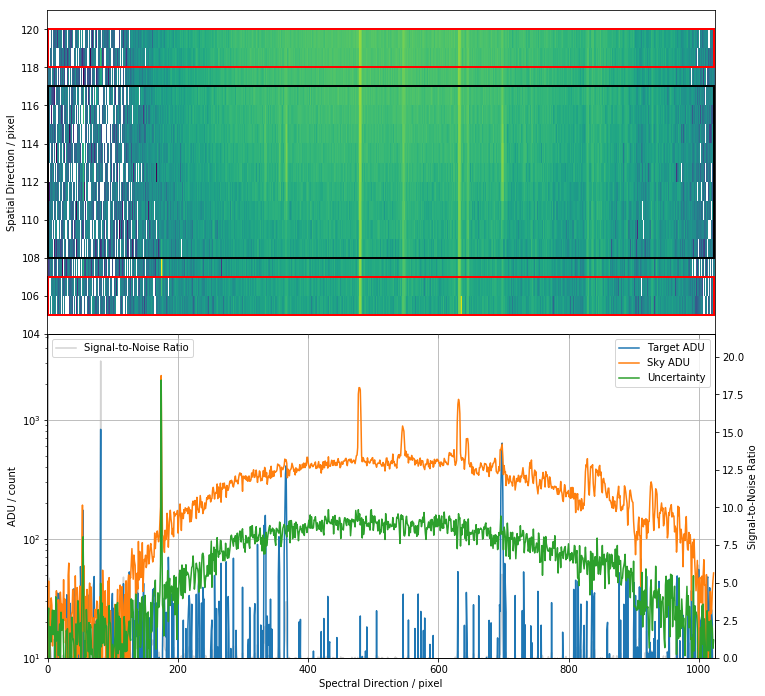

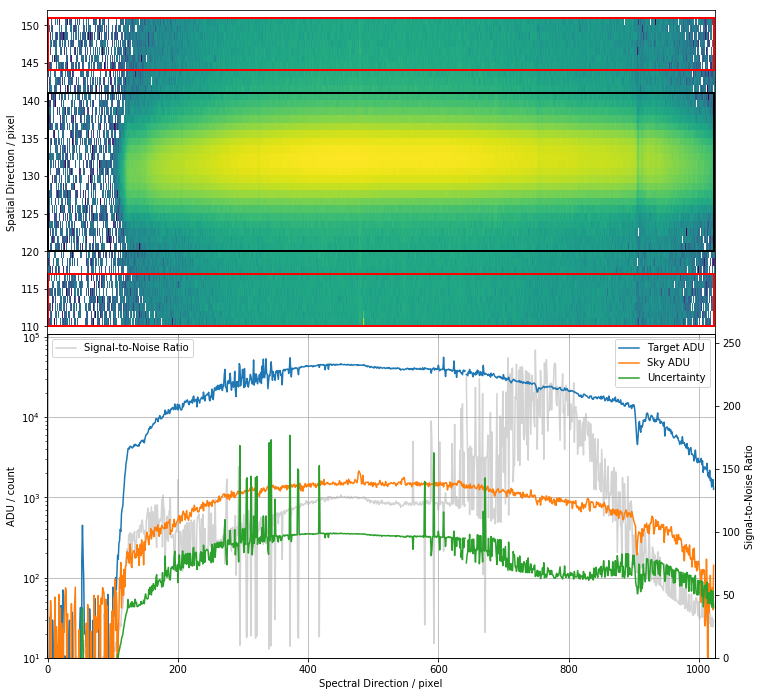

In [5]:
# Aperture extracting spectrum by summing over the aperture along the trace
at2019.ap_extract(apwidth=4, optimal=False, skysep=1, skywidth=2)
bdp33.ap_extract(apwidth=10)

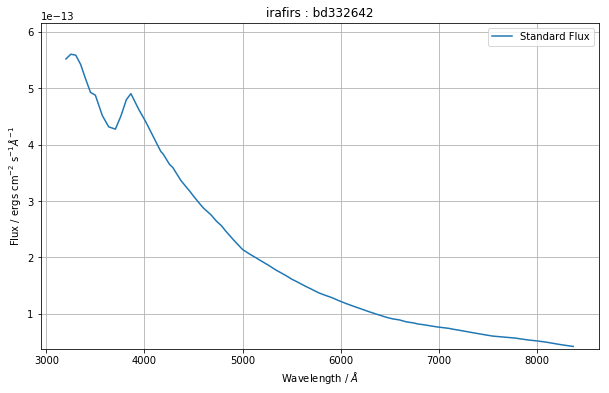

In [6]:
fluxcal = aspired.StandardFlux(target='bd332642', group='irafirs', cutoff=0.4, ftype='flux')
fluxcal.load_standard()
fluxcal.inspect_standard()

In [7]:
# Placeholder of wavelength calibration
wavecal = type('', (), {})()
wavecal.pfit_type = 'poly'
wavecal.pfit = [3.17707768e-07, -6.15874242e-04,  5.13807283e+00,  3.22724313e+03]


/Users/marcolam/git/SpectRes/spectres/spectral_resampling.py:74: UserWarning: spectres: Part of the new wavelengths specified is outside the range of the input data, they are filled with zeros.
  warnings.warn("spectres: Part of the new wavelengths specified is "
aspired/aspired.py:1422: RuntimeWarning: divide by zero encountered in true_divide
  sensitivity = flux_std_true / flux_std
aspired/aspired.py:1427: RuntimeWarning: invalid value encountered in greater
  ((self.wave_std_true<7150.)|(self.wave_std_true>7400.)) &


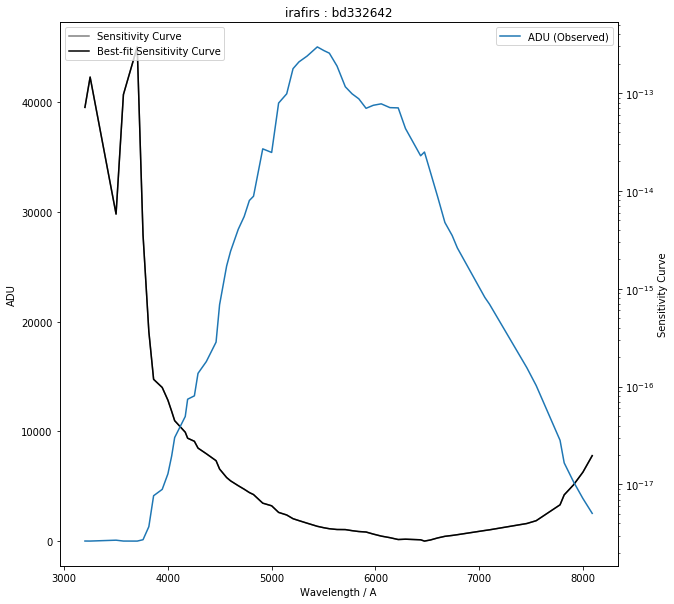

In [8]:
# Get the sensitivity curves
at2019_reduced = aspired.OneDSpec(at2019, wavecal, standard=bdp33, wave_cal_std=wavecal, flux_cal=fluxcal)
at2019_reduced.apply_wavelength_calibration('all')
at2019_reduced.compute_sencurve(kind='cubic')
at2019_reduced.inspect_sencurve()

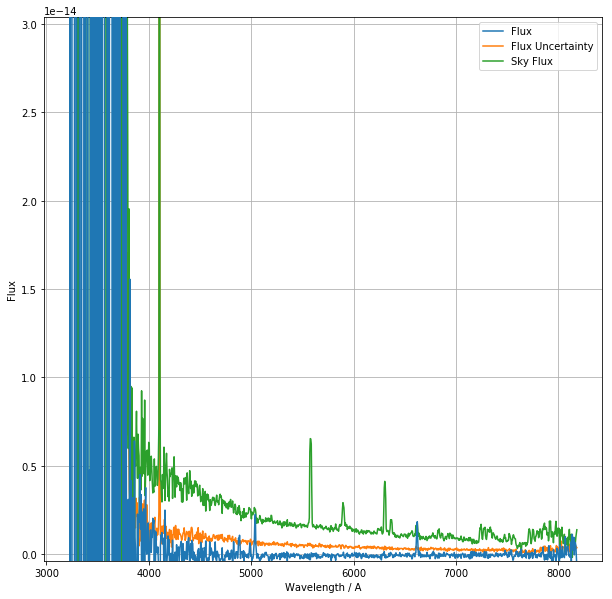

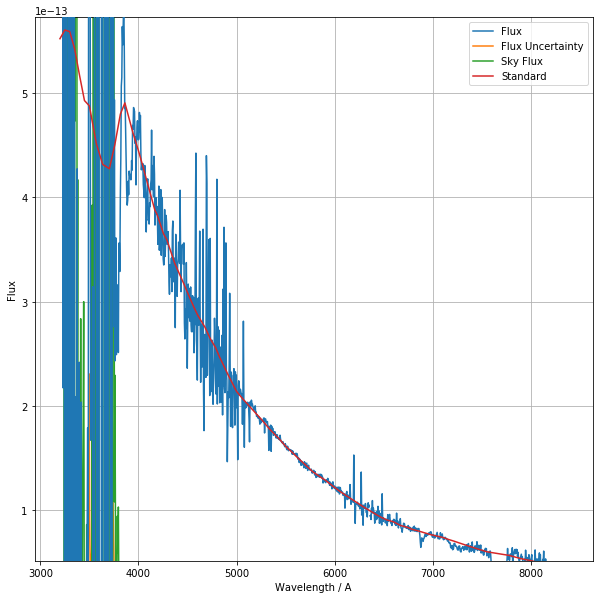

In [9]:
at2019_reduced.apply_flux_calibration('all')
at2019_reduced.inspect_reduced_spectrum('all')

(-1.0677366547385576e-15, 1.7816981216596723e-15)

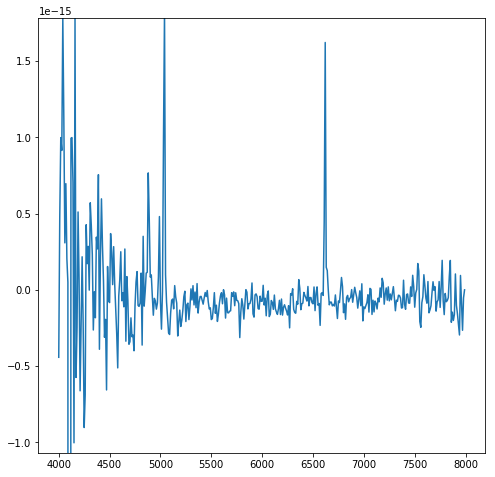

In [10]:
wave_at2019, flux_at2019 = at2019_reduced.wave, at2019_reduced.flux
wave = np.arange(4000.,8000.,10.)
flux = spectres(wave, wave_at2019, flux_at2019)
plt.figure(figsize=(8,8))
plt.plot(wave, flux)
plt.ylim(np.percentile(flux,0.5),np.percentile(flux,99.5))